In [3]:
from model import create_model

In [1]:
#  download dlib for face_preprocess
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

## Custom Dataset
To demonstrate face recognition on a custom dataset, a small subset of the LFW dataset is used. It consists of 100 face images of 10 identities. The metadata for each image (file and identity name) are loaded into memory for later processing.

In [5]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

In [8]:
metadata[0]

images/Ariel_Sharon/Ariel_Sharon_0001.jpg

## Face Alignment
The nn4.small2.v1 model was trained with aligned face images, therefore, the face images from the custom dataset must be aligned too. Here, we use Dlib for face detection and OpenCV for image transformation and cropping to produce aligned 96x96 RGB face images. By using the AlignDlib utility from the OpenFace project this is straightforward:


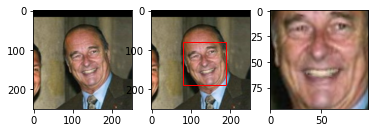

In [22]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[77].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [24]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img),landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
                                                            

## Find embedding using pretrained model

In [109]:
img = np.array(list(map(align_image,map(load_image,[m.image_path() for m in metadata])))).astype('float')/255.0
print("Image shape: ",img.shape)

Image shape:  (100, 96, 96, 3)


In [126]:
dx = tf.data.Dataset.from_tensor_slices(img).shuffle(1024).batch(20)

In [125]:
dx

<TensorSliceDataset shapes: (96, 96, 3), types: tf.float64>

## Model Defination


In [142]:
# !pip install -q -U tensorflow-addons
! pip install tensorflow.datasets


     |████████████████████████████████| 3.5 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 333 kB/s  eta 0:00:01
     |████████████████████████████████| 177 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 91 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 100 kB 2.7 MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21495 sha256=d42ba81643123e3d37e6ca983b667160ad983f6a0fc51060939185e66899df69
  Stored in directory: /home/raghav/.cache/pip/wheels/54/aa/01/724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
  Created wheel for dill: filename=dill-0.3.2-py3-none-any.whl size=78912 sha256=056e726990b96d39a541b66658ac46458a1442ead6ae3b95aa8b2376c7075369
  Stored in directory: /home/raghav/.cache/pip/wheels/93/7f/7d/78ec535a4340ef2696aad8b17fe8bb063d56301bd62881b069
Successfully built promise dill


In [143]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
# open pre-trained model 
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')


In [144]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(96,96,3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())
history = model.fit(
    dx,
    epochs=5)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /home/raghav/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Epoch 1/5


ValueError: in user code:

    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2736 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1270 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv2d_10/kernel:0', 'conv2d_10/bias:0', 'conv2d_11/kernel:0', 'conv2d_11/bias:0', 'dense_5/kernel:0', 'dense_5/bias:0'].


In [132]:
# Compile the model
nn4_small2_pretrained.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())


In [131]:
# Train the network
history = nn4_small2_pretrained.fit(
    dx,
    epochs=5)


Epoch 1/5


ValueError: in user code:

    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2736 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /home/raghav/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1270 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv1/kernel:0', 'conv1/bias:0', 'bn1/gamma:0', 'bn1/beta:0', 'conv2/kernel:0', 'conv2/bias:0', 'bn2/gamma:0', 'bn2/beta:0', 'conv3/kernel:0', 'conv3/bias:0', 'bn3/gamma:0', 'bn3/beta:0', 'inception_3a_3x3_conv1/kernel:0', 'inception_3a_3x3_conv1/bias:0', 'inception_3a_5x5_conv1/kernel:0', 'inception_3a_5x5_conv1/bias:0', 'inception_3a_3x3_bn1/gamma:0', 'inception_3a_3x3_bn1/beta:0', 'inception_3a_5x5_bn1/gamma:0', 'inception_3a_5x5_bn1/beta:0', 'inception_3a_pool_conv/kernel:0', 'inception_3a_pool_conv/bias:0', 'inception_3a_3x3_conv2/kernel:0', 'inception_3a_3x3_conv2/bias:0', 'inception_3a_5x5_conv2/kernel:0', 'inception_3a_5x5_conv2/bias:0', 'inception_3a_pool_bn/gamma:0', 'inception_3a_pool_bn/beta:0', 'inception_3a_1x1_conv/kernel:0', 'inception_3a_1x1_conv/bias:0', 'inception_3a_3x3_bn2/gamma:0', 'inception_3a_3x3_bn2/beta:0', 'inception_3a_5x5_bn2/gamma:0', 'inception_3a_5x5_bn2/beta:0', 'inception_3a_1x1_bn/gamma:0', 'inception_3a_1x1_bn/beta:0', 'inception_3b_3x3_conv1/kernel:0', 'inception_3b_3x3_conv1/bias:0', 'inception_3b_5x5_conv1/kernel:0', 'inception_3b_5x5_conv1/bias:0', 'inception_3b_3x3_bn1/gamma:0', 'inception_3b_3x3_bn1/beta:0', 'inception_3b_5x5_bn1/gamma:0', 'inception_3b_5x5_bn1/beta:0', 'inception_3b_pool_conv/kernel:0', 'inception_3b_pool_conv/bias:0', 'inception_3b_3x3_conv2/kernel:0', 'inception_3b_3x3_conv2/bias:0', 'inception_3b_5x5_conv2/kernel:0', 'inception_3b_5x5_conv2/bias:0', 'inception_3b_pool_bn/gamma:0', 'inception_3b_pool_bn/beta:0', 'inception_3b_1x1_conv/kernel:0', 'inception_3b_1x1_conv/bias:0', 'inception_3b_3x3_bn2/gamma:0', 'inception_3b_3x3_bn2/beta:0', 'inception_3b_5x5_bn2/gamma:0', 'inception_3b_5x5_bn2/beta:0', 'inception_3b_1x1_bn/gamma:0', 'inception_3b_1x1_bn/beta:0', 'inception_3c_3x3_conv1/kernel:0', 'inception_3c_3x3_conv1/bias:0', 'inception_3c_5x5_conv1/kernel:0', 'inception_3c_5x5_conv1/bias:0', 'inception_3c_3x3_bn1/gamma:0', 'inception_3c_3x3_bn1/beta:0', 'inception_3c_5x5_bn1/gamma:0', 'inception_3c_5x5_bn1/beta:0', 'inception_3c_3x3_conv2/kernel:0', 'inception_3c_3x3_conv2/bias:0', 'inception_3c_5x5_conv2/kernel:0', 'inception_3c_5x5_conv2/bias:0', 'inception_3c_3x3_bn2/gamma:0', 'inception_3c_3x3_bn2/beta:0', 'inception_3c_5x5_bn2/gamma:0', 'inception_3c_5x5_bn2/beta:0', 'inception_4a_3x3_conv1/kernel:0', 'inception_4a_3x3_conv1/bias:0', 'inception_4a_5x5_conv1/kernel:0', 'inception_4a_5x5_conv1/bias:0', 'inception_4a_3x3_bn1/gamma:0', 'inception_4a_3x3_bn1/beta:0', 'inception_4a_5x5_bn1/gamma:0', 'inception_4a_5x5_bn1/beta:0', 'inception_4a_pool_conv/kernel:0', 'inception_4a_pool_conv/bias:0', 'inception_4a_3x3_conv2/kernel:0', 'inception_4a_3x3_conv2/bias:0', 'inception_4a_5x5_conv2/kernel:0', 'inception_4a_5x5_conv2/bias:0', 'inception_4a_pool_bn/gamma:0', 'inception_4a_pool_bn/beta:0', 'inception_4a_1x1_conv/kernel:0', 'inception_4a_1x1_conv/bias:0', 'inception_4a_3x3_bn2/gamma:0', 'inception_4a_3x3_bn2/beta:0', 'inception_4a_5x5_bn2/gamma:0', 'inception_4a_5x5_bn2/beta:0', 'inception_4a_1x1_bn/gamma:0', 'inception_4a_1x1_bn/beta:0', 'inception_4e_3x3_conv1/kernel:0', 'inception_4e_3x3_conv1/bias:0', 'inception_4e_5x5_conv1/kernel:0', 'inception_4e_5x5_conv1/bias:0', 'inception_4e_3x3_bn1/gamma:0', 'inception_4e_3x3_bn1/beta:0', 'inception_4e_5x5_bn1/gamma:0', 'inception_4e_5x5_bn1/beta:0', 'inception_4e_3x3_conv2/kernel:0', 'inception_4e_3x3_conv2/bias:0', 'inception_4e_5x5_conv2/kernel:0', 'inception_4e_5x5_conv2/bias:0', 'inception_4e_3x3_bn2/gamma:0', 'inception_4e_3x3_bn2/beta:0', 'inception_4e_5x5_bn2/gamma:0', 'inception_4e_5x5_bn2/beta:0', 'inception_5a_3x3_conv1/kernel:0', 'inception_5a_3x3_conv1/bias:0', 'inception_5a_3x3_bn1/gamma:0', 'inception_5a_3x3_bn1/beta:0', 'inception_5a_pool_conv/kernel:0', 'inception_5a_pool_conv/bias:0', 'inception_5a_3x3_conv2/kernel:0', 'inception_5a_3x3_conv2/bias:0', 'inception_5a_pool_bn/gamma:0', 'inception_5a_pool_bn/beta:0', 'inception_5a_1x1_conv/kernel:0', 'inception_5a_1x1_conv/bias:0', 'inception_5a_3x3_bn2/gamma:0', 'inception_5a_3x3_bn2/beta:0', 'inception_5a_1x1_bn/gamma:0', 'inception_5a_1x1_bn/beta:0', 'inception_5b_3x3_conv1/kernel:0', 'inception_5b_3x3_conv1/bias:0', 'inception_5b_3x3_bn1/gamma:0', 'inception_5b_3x3_bn1/beta:0', 'inception_5b_pool_conv/kernel:0', 'inception_5b_pool_conv/bias:0', 'inception_5b_3x3_conv2/kernel:0', 'inception_5b_3x3_conv2/bias:0', 'inception_5b_pool_bn/gamma:0', 'inception_5b_pool_bn/beta:0', 'inception_5b_1x1_conv/kernel:0', 'inception_5b_1x1_conv/bias:0', 'inception_5b_3x3_bn2/gamma:0', 'inception_5b_3x3_bn2/beta:0', 'inception_5b_1x1_bn/gamma:0', 'inception_5b_1x1_bn/beta:0', 'dense_layer/kernel:0', 'dense_layer/bias:0'].


In [73]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.linalg.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        

        mask = tf.dtypes.cast(tf.equal(distances, 0.0),tf.float32)
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

In [91]:
def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask

def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask
def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.dtypes.cast(mask_anchor_positive,tf.float32)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.dtypes.cast(mask_anchor_negative, tf.float32)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss


In [103]:
embedded[0]
embeddings = embedded[1:,:]

(99, 128)

TensorShape([128, 128])

In [107]:
batch_hard_triplet_loss(embedded[0], embeddings, margin=0.02, squared=False)

InvalidArgumentError: Incompatible shapes: [128,128] vs. [99,99] [Op:Mul]